## Load Libraries

In [1]:
import transformers
from transformers import pipeline
import numpy as np
import pandas as pd
import shap
from transformers import pipeline
from html2image import Html2Image
import matplotlib.pyplot as plt


c:\Users\Mohamed Khalil\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [ ]:
# Load the Excel file
cluster_df = pd.read_excel(r'C:\Users\Mohamed Khalil\Desktop\Reviews_Clustering\Reviews_Research_LLM\Data\output_phase1.xlsx')

In [ ]:
sentence = "Create feedback not working. Every other admin functionality working properly."
shap_values = explain_sentiment_with_shap(sentence)

Device set to use cpu


In [19]:
plot_shap_text_explanation(shap_values)

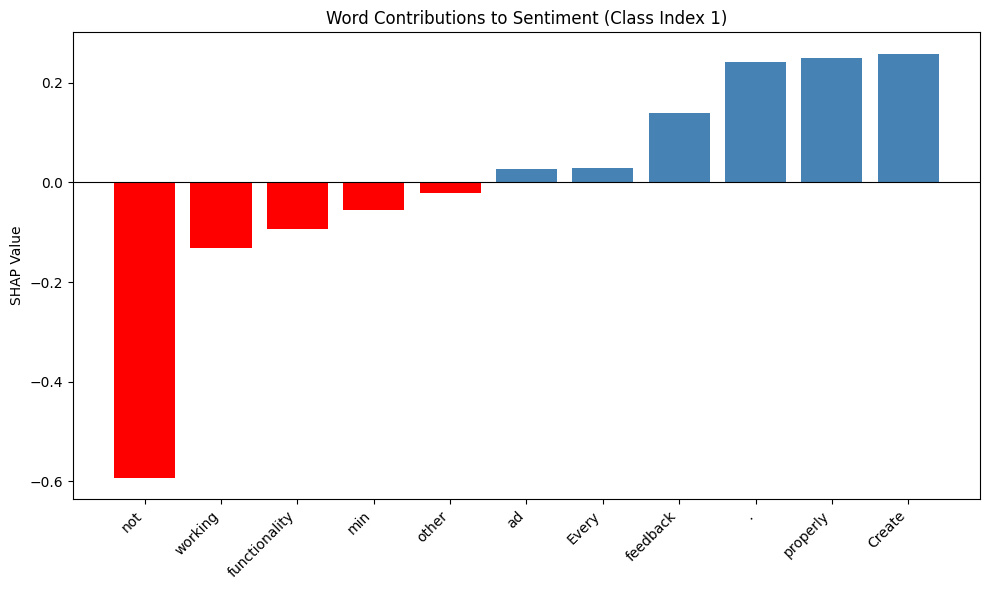

In [33]:
plot_shap_bar_from_text(shap_values[0])

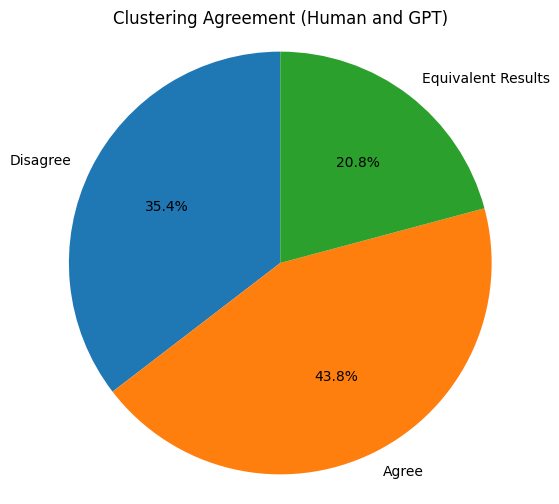

In [40]:
score_counts = get_persuasion_score_counts(cluster_df)
plot_persuasion_pie(score_counts)


In [16]:
def explain_sentiment_with_shap(sentence: str):
    """
    Takes a sentence as input, computes SHAP values using a sentiment classifier,
    and visualizes token-level contribution with shap.plots.text.
    """
    # Load the model and SHAP explainer once globally
    classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
    explainer = shap.Explainer(classifier)
    shap_values = explainer([sentence])

    return shap_values



In [39]:
def get_persuasion_score_counts(df, column='Persuation_Score'):
    """
    Counts and sorts the occurrences of each persuasion score in a DataFrame.
    """
    return df[column].value_counts().sort_index()


In [37]:
def plot_shap_text_explanation(shap_values):
    shap.plots.text(shap_values)

In [36]:
def plot_persuasion_pie(score_counts, zero_label="Disagree", one_label="Agree", two_label="Equivalent Results"):
    """
    Plots a pie chart of clustering agreement scores (0, 1, 2) using custom labels.
    """
    label_map = {
        0: zero_label,
        1: one_label,
        2: two_label
    }
    labels = [label_map.get(score, str(score)) for score in score_counts.index]

    # Plot as pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(score_counts, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Clustering Agreement (Human and GPT)')
    plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart
    plt.show()


In [ ]:
def plot_shap_bar_from_text(shap_values, class_index=1, threshold=0.01):
    """
    Generate a bar plot of SHAP values for a specific class.
    - shap_values: shap.Explanation object for a single instance.
    - class_index: Index of the class to visualize (default is 1 for positive).
    - threshold: Minimum absolute SHAP value to include in the plot.
    """
    tokens = shap_values.data[0] if isinstance(shap_values.data, tuple) else shap_values.data

    values_array = shap_values.values
    if values_array.ndim == 3:
        values = values_array[0][:, class_index]
    elif values_array.ndim == 2:
        values = values_array[:, class_index]
    else:
        raise ValueError("Unexpected SHAP values shape: {}".format(values_array.shape))

    # Filter based on threshold
    filtered = [(tok.strip(), val) for tok, val in zip(tokens, values) if abs(val) >= threshold]

    if len(filtered) == 0:
        print("No SHAP values above threshold.")
        return

    words, scores = zip(*filtered)
    sorted_indices = np.argsort(scores)
    words_sorted = np.array(words)[sorted_indices]
    scores_sorted = np.array(scores)[sorted_indices]

    colors = ['red' if val < 0 else 'steelblue' for val in scores_sorted]

    plt.figure(figsize=(10, 6))
    plt.bar(words_sorted, scores_sorted, color=colors)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("SHAP Value")
    plt.title(f"Word Contributions to Sentiment (Class Index {class_index})")
    plt.tight_layout()
    plt.show()


In [ ]:
Average NMI: 0.816
Average F1-score: 0.806
Average Adjusted Rand Index (ARI): 0.680
Total skipped rows due to errors: 4